### Import thư viện <a class="anchor" id="c14"></a>

In [49]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Xử lí dữ liệu input <a class="anchor" id="c14"></a>

In [50]:
def get_image(filename):
    try:
        # mở image từ filename
        img=Image.open(filename)
        # chuyển image thành np array
        img =  np.array(img)
        return img
    except:
        print("Cannot open file. Please check again :()")
        exit(0)

### 1. Thay đổi độ sáng <a class="anchor" id="c14"></a>

In [51]:
def change_brightness(img,brightness):
    # cộng từng phần tử trong kênh màu với giá trị brightness
    return np.clip(img+np.array([brightness]),0,255).astype(np.uint8)

### 2. Thay đổi độ tương phản <a class="anchor" id="c14"></a>

In [52]:
def change_contrast(img,contrast):
    # công thức tính factor contrast
    factor = (259*(contrast+255))/(255*(259-contrast))
    result = np.clip(factor * (img.astype(float) - 128) + 128, 0, 255)
    return result.astype(np.uint8)

### 3. Lật ảnh <a class="anchor" id="c14"></a>

In [53]:
def flip_image(img,type):
    # type 1: lật dọc
    if type==1:
        return np.flipud(img)
    # type 2: lật ngang
    elif type==2:
        return np.fliplr(img)

### 4. Chuyển đổi RGB sang Grayscale / Sepia <a class="anchor" id="c14"></a>

In [54]:
def rgb_to_grayscale(img):
    # khởi tạo mảng result để lưu trữ ảnh sau khi chuyển đổi
    result = np.empty(img.shape)
    # chạy vòng lặp qua số lượng kênh màu
    for i in range(3):
         # nhân từng giá trị r,g,b trong kênh màu rgb của từng pixel với các tham số
            result[:,:,i] = 0.2989*img[:,:,0]+0.5870*img[:,:,1]+0.1140*img[:,:,2]
    return np.clip(result,0,255).astype(np.uint8)

def rgb_to_sepia(img):
    # khởi tạo mảng result để lưu trữ ảnh sau khi chuyển đổi
    result = np.empty(img.shape)

    result[:, :, 0] = 0.393 * img[:, :, 0] + 0.769 * img[:, :, 1] + 0.189 * img[:, :, 2]
    result[:, :, 1] = 0.349 * img[:, :, 0] + 0.686 * img[:, :, 1] + 0.168 * img[:, :, 2]
    result[:, :, 2] = 0.272 * img[:, :, 0] + 0.534 * img[:, :, 1] + 0.131 * img[:, :, 2]
    return np.clip(result,0,255).astype(np.uint8)

### 5. Làm mờ / sắc nét  <a class="anchor" id="c14"></a>

### a. Làm mờ <a class="anchor" id="c14"></a>

In [55]:
def create_summed_area_table(img):
    height, width, _ = img.shape
    # khởi tạo summed-area-table
    sat = np.zeros_like(img)
    # gán giá trị phần tử [0,0] của sat
    sat[0, 0] = img[0, 0]
    
    for x in range(1,height):
        for y in range(1,width):
                # giá trị phía trên
                top = sat[x-1, y]
                # giá trị bên trái
                left = sat[x, y-1]
                # giá trị ở góc chéo trái trên
                diagonal = sat[x-1, y-1]
                # giá trị của phần tử trong sat tại vị trí x,y = láy giá trị bên trái nó + giá trị phía trên nó - giá trị góc chéo trái trên
                sat[x, y] = img[x, y]+top+left-diagonal
    return sat

def box_blur(img, radius):
    # đổi type của data array
    img_ = img.astype(np.uint16)
    
    height,width,_ = img_.shape
    # mảng result chứa giá trị ảnh sau khi làm mờ copy từ mảng ảnh gốc
    result = img_.copy()
    # diện tích của kernel
    area = (2*radius + 1)**2
    # summed-area table
    sat = create_summed_area_table(img_)
    # mảng chứa giá trị tổng các pixels
    sum_pixels = np.zeros(3)
    
    for x in range(radius+1, height-radius-1):
        for y in range(radius+1, width-radius-1):
            sum_pixels = np.add(np.subtract(np.subtract(
                sat[x+radius, y+radius], sat[x+radius, y-radius-1]), sat[x-radius-1, y+radius]), sat[x-radius-1, y-radius-1])
            result[x,y] = np.clip((sum_pixels/area),0,255)

    return result.astype(np.uint8)

### b. Làm sắc nét <a class="anchor" id="c14"></a>

In [56]:
def convolution(img, kernel):
    # Sử dụng hàm np.pad để padding ảnh với zeros
    padding_height = kernel.shape[0] // 2
    padding_width = kernel.shape[1] // 2
    padded_img = np.pad(img, ((padding_height, padding_height), (padding_width, padding_width), (0, 0)), mode='constant')

    # Sử dụng hàm np.roll để thực hiện convolution
    result = np.zeros(img.shape)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            for c in range(3):
                value = np.sum(padded_img[x:x+kernel.shape[0], y:y+kernel.shape[1], c] * kernel)
                result[x, y, c] = value

    return np.clip(result, 0, 255).astype(np.uint8)

def sharpen_image(img):
    # sử dụng laplacian filter
    laplacian_filter =np.array([[0, -1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
    # chập img với kernel
    return convolution(img, laplacian_filter)

### 6. Cắt ảnh theo kích thước (cắt ở trung tâm) <a class="anchor" id="c14"></a>

In [57]:
def crop_center(img,crop_height,crop_width):
    height,width,_= img.shape
    
    left = (width - crop_width) // 2
    upper = (height - crop_height) // 2
    right = left + crop_width
    lower = upper + crop_height
    
    return img[upper:lower,left:right].astype(np.uint8)

### 7. Cắt ảnh theo khung hình tròn <a class="anchor" id="c14"></a>

In [58]:
def crop_circle_frame(img,radius):
    height, width = img.shape[:2]
    center = (width // 2, height // 2)

    # Tạo một mảng x, y chứa tọa độ các pixel trong ảnh
    y, x = np.ogrid[:height, :width]

    # Tính khoảng cách từ mỗi pixel tới tâm của hình tròn
    dist_from_center = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)

    # Tạo mask để chọn các pixel nằm trong hình tròn 
    mask = dist_from_center <= radius

    # Chỉ giữ lại các pixel nằm trong hình tròn
    result = np.copy(img)
    result[~mask] = 0
    
    return result.astype(np.uint8)


### 8. Cắt theo khung 2 hình ellip chéo <a class="anchor" id="c14"></a>

### a. Tạo mask là elip chép <a class="anchor" id="c14"></a>

In [59]:
def create_rotated_elip_mask(img,rotation_angle,major_axis,minor_axis):
    height,width,_=img.shape
    
    # Tạo một mảng x, y chứa tọa độ các pixel trong ảnh
    y, x = np.ogrid[:height, :width]
    
    # Tâm của ảnh
    center_x, center_y = width // 2, height // 2
    
    # Điều chỉnh tọa độ để căn giữa mask tại tâm elip
    x -= center_x
    y -= center_y
    
    # Áp dụng phép quay cho các tọa độ của elip
    rotation_angle = np.deg2rad(rotation_angle) # chuyển về radian
    x_rotated = x * np.cos(rotation_angle) - y * np.sin(rotation_angle)
    y_rotated = x * np.sin(rotation_angle) + y * np.cos(rotation_angle)
    
    # Tạo mask cho elip chéo
    mask = (x_rotated / major_axis) ** 2 + (y_rotated / minor_axis) ** 2 <= 1
    
    return mask.astype(np.uint8)

### b. Cắt <a class="anchor" id="c14"></a>

In [60]:
def crop_2elips_frame(img,major_axis,minor_axis):
    height, width, _ = img.shape
    # tạo 1 mảng mới chứa dữ liệu ảnh
    result = img.copy()
    # Tạo mask
    elip1 = create_rotated_elip_mask(img,45, major_axis, minor_axis)
    elip2 = create_rotated_elip_mask(img,135, major_axis, minor_axis)
    # kết hợp 2 mask elip
    mask = elip1 | elip2

    for i in range(height):
        for j in range(width):
            if mask[i, j] == 0:
                result[i, j] = 0

    return result.astype(np.uint8)

### Lưu ảnh <a class="anchor" id="c14"></a>

In [61]:
def output_file(img, filename, ext):
    try:
        # chuyển image thành đối tượng hình ảnh PIL
        img = Image.fromarray(img.astype(np.uint8))
        img.save(filename+'.'+ext)
    except:
        print("Cannot save this file")
        return

### Hàm thực thi các chức năng <a class="anchor" id="c14"></a>

In [62]:
def running_function(option,input_file,output_file_ext):
    img = get_image(input_file)
    
    # Tìm vị trí của dấu chấm cuối cùng trong tên tập tin
    last_dot_index = input_file.rfind('.')
    # Lấy tên tập tin (không bao gồm phần mở rộng)
    input_filename = input_file[:last_dot_index]
    
    # khởi tạo mảng ảnh mới
    new_img = np.empty(img.shape)
    
    if option == 1:
        br = float(input("Enter the brightness change: "))
        new_img = change_brightness(img, br)
        output_file(new_img,input_filename+'_brightness',output_file_ext)
    elif option == 2:
        contrast_factor = float(input("Enter the contrast: "))
        new_img = change_contrast(img, contrast_factor)
        output_file(new_img,input_filename+'_contrast',output_file_ext)
    elif option == 3:
        type = int(
            input("1.Flip horizontally 2.Flip vertically Please enter your choice:"))
        new_img = flip_image(img, type)
        output_file(new_img,input_filename+'_flip',output_file_ext)
    elif option == 4:
        sub_op = int(
            input("1.Turn into grayscale 2.Turn into sepia  Please enter your choice:"))
        if sub_op == 1:
            new_img = rgb_to_grayscale(img)
            output_file(new_img,input_filename+'_grayscale',output_file_ext)
        elif sub_op == 2:
            new_img = rgb_to_sepia(img)
            output_file(new_img,input_filename+'_sepia',output_file_ext)
        else:
            print("Invalid value.")
    elif option == 5:
        type = int(input("Enter your choice: 1.Blurring 2.Sharpening"))
        if type==1:
            r = int(input("Enter the kernel radius: "))
            new_img = box_blur(img,r)
            output_file(new_img,input_filename+'_blur',output_file_ext)
        elif type ==2:
            new_img = sharpen_image(img)
            output_file(new_img,input_filename+'_sharpen',output_file_ext)
    elif option == 6:
        crop_height = int(input("Enter the height of crop image: "))
        crop_width = int(input("Enter the width of crop image: "))
        new_img = crop_center(img, crop_height, crop_width)
        output_file(new_img,input_filename+'_crop_center',output_file_ext)
    elif option == 7:
        radius = int(input("Enter the radius: "))
        new_img = crop_circle_frame(img, radius)
        output_file(new_img,input_filename+'_crop_circle',output_file_ext)
    elif option == 8:
        major = int(input("Enter the value of major axis: "))
        minor = int(input("Enter the value of minor axis: "))
        new_img = crop_2elips_frame(img,major,minor)
        output_file(new_img,input_filename+'_crop_2_elip',output_file_ext)
    
    return new_img.astype(np.uint8)

### MAIN <a class="anchor" id="c14"></a>

In [63]:
input_file = input("Enter input file: ")
img=get_image(input_file)

# Nhập ext của output file
ext = input("Enter the output file extension(png/jpg/pdf): ")

# Nhập option của các chức năng
option = int(input("Enter your choice: 0.Doing all 1.Changing the brightness 2.Changing the contrast 3.Flipping image 4.Converting into gray/sepia 5.Blurring\sharpening 6.Cropping in center 7.Cropping into circle frame 8. Cropping into 2elips frame"))

# get data array của image
img = get_image(input_file)

# thực thi các chức năng
if option == 0:
    for i in range(1,9):
        new_img = running_function(i,input_file,ext)
else:
    new_img = running_function(option,input_file,ext)

### Show ảnh <a class="anchor" id="c14"></a>

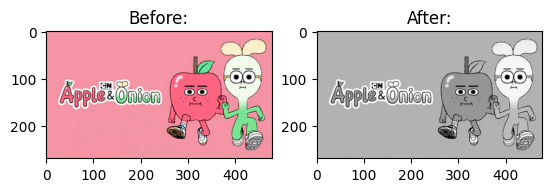

In [64]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img)
axes[0].set_title('Before:');
axes[1].imshow(new_img)
axes[1].set_title('After:');